## EDA, ML Colab, ML BigQuery, Cohorts, RFM, GigaChat

### Импорт библиотек и датасета

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter

import plotly.express as px
import plotly.graph_objects as go

import plotly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Курсовая/eCom events history in Cosmetics shop.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
df = pd.concat([pd.read_csv('/content/2019-Oct.csv', parse_dates=['event_time']),
                pd.read_csv('/content/2019-Nov.csv', parse_dates=['event_time']),
                pd.read_csv('/content/2019-Dec.csv', parse_dates=['event_time']),
                pd.read_csv('/content/2020-Jan.csv', parse_dates=['event_time'])
                #,pd.read_csv('/content/2020-Feb.csv', parse_dates=['event_time'])
                ],
                ignore_index = True)

In [ ]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,cart,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
1,2019-10-01 00:00:03+00:00,cart,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
2,2019-10-01 00:00:07+00:00,cart,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9
3,2019-10-01 00:00:07+00:00,cart,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885
4,2019-10-01 00:00:15+00:00,cart,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16536158 entries, 0 to 16536157
Data columns (total 9 columns):
 #   Column         Dtype              
---  ------         -----              
 0   event_time     datetime64[ns, UTC]
 1   event_type     object             
 2   product_id     int64              
 3   category_id    int64              
 4   category_code  object             
 5   brand          object             
 6   price          float64            
 7   user_id        int64              
 8   user_session   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(3), object(4)
memory usage: 1.1+ GB


In [ ]:
df['product_id'] = df['product_id'].astype('object')
df['category_id'] = df['category_id'].astype('object')
df['user_id'] = df['user_id'].astype('object')

In [ ]:
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
category_code,16259749
brand,6931209
price,0
user_id,0
user_session,3543


In [ ]:
(len(df)-df['category_code'].isna().sum())/len(df)*100

np.float64(1.6715430512940186)

Пропуски в **brand, user_session** не критичны, их можно заполнить.
**category_code** при этом практически отсутствует в датасете, поэтому эту колонку можно удалить (данные заполнны на 1.5% )

In [ ]:
df = df.drop(['category_code'], axis = 1)
df['brand'] = df['brand'].fillna('no_brand_data')
df['user_session'] = df['user_session'].fillna('user_session')

In [ ]:
df.isna().sum()

,0
event_time,0
event_type,0
product_id,0
category_id,0
brand,0
price,0
user_id,0
user_session,0


Event types can be:

* view - a user viewed a product
* cart - a user added a product to shopping cart
* remove_from_cart - a user removed a product from shopping cart
* purchase - a user purchased a product

In [ ]:
df = df.drop_duplicates(keep='first', inplace=False, ignore_index=False)

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'].dt.date)

In [ ]:
len(df)

15667350

In [ ]:
df.to_csv("/content/dataset_preproc.csv")

### Экспорт датасета в BQ для дальнейшей обработки при помощи SQL и хранения предобработанных данных

In [ ]:
#Dataset with Table name variable
BqDatasetwithtable='TermPaper.ecom_cosmetics_raw_data'
#BQproject name variable
BqProject='guzel-2021-a9e57'
# pandas-gbq method to load data
# append data if data table exists in BQ project
# set chunk size of records to be inserted
df.to_gbq(BqDatasetwithtable, BqProject,chunksize=10000, if_exists='append' )

### Импорт датасета из BQ для дальнейшей обработки в Colab

In [ ]:
from google.cloud import bigquery
!pip install db-dtypes

from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
PROJECT_ID = 'guzel-2021-a9e57' # Change to your project.
REGION = 'US'

In [ ]:
%%bigquery df --project $PROJECT_ID

SELECT event_type, event_time, product_id, category_id, brand, price, user_id, user_session
FROM `TermPaper.ecom_cosmetics_raw_data`

In [ ]:
df.head()

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session
0,remove_from_cart,2019-11-27 13:59:23+00:00,5814156,1842735758805303837,beauty-free,2.37,559069603,5a081350-f8b6-4602-bea9-95904fba7bfc
1,remove_from_cart,2019-11-04 19:23:04+00:00,5814533,1487580006895846315,runail,6.27,567582655,1590e282-2011-4eb7-9f9a-3d3848450391
2,remove_from_cart,2019-10-18 04:31:56+00:00,5636699,1487580008858779653,milv,1.75,411887559,afe0cad2-567b-4b0f-aa99-d4f61e913dee
3,remove_from_cart,2019-10-21 11:12:19+00:00,5645815,1487580008774893569,milv,2.70,526291364,b2e81772-c460-ff03-2b6e-f4fc4ae77c15
4,remove_from_cart,2019-12-04 21:03:05+00:00,5650431,1487580007952810971,metzger,8.33,577330884,e2aff442-987c-4263-8243-3ba002bace12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15667350 entries, 0 to 15667349
Data columns (total 8 columns):
 #   Column        Dtype              
---  ------        -----              
 0   event_type    object             
 1   event_time    datetime64[us, UTC]
 2   product_id    Int64              
 3   category_id   Int64              
 4   brand         object             
 5   price         float64            
 6   user_id       Int64              
 7   user_session  object             
dtypes: Int64(3), datetime64[us, UTC](1), float64(1), object(3)
memory usage: 1001.1+ MB


### EDA в Colab

In [ ]:
df.describe()

,product_id,category_id,price,user_id
count,15667350.0,15667350.0,1.566735e+07,15667350.0
mean,5476828.913487,1552380877285994496.0,8.734714e+00,516134707.473555
std,1316671.755375,166509870677099744.0,1.970453e+01,86186907.056452
min,3752.0,1487580004807082752.0,-7.937000e+01,465496.0
25%,5724283.0,1487580005754995456.0,2.130000e+00,478509130.0
50%,5809912.0,1487580008263189504.0,4.110000e+00,550257646.0
75%,5856252.0,1487580013506068736.0,7.140000e+00,572005916.0
max,5924514.0,2235524499636224256.0,3.277800e+02,608822072.0


In [ ]:
print(" Минимальная дата", df['event_time'].min(), '\n', "Максимальная дата", df['event_time'].max())

 Минимальная дата 2019-10-01 00:00:00+00:00 
 Максимальная дата 2020-01-31 23:59:58+00:00


In [ ]:
df_summ = df.groupby('event_type').agg({"user_session": "nunique", "price": "sum"}).rename(columns = {'user_session': 'count_events'}).\
            reset_index().sort_values(by=['count_events', 'price'], ascending = False)
df_summ

,event_type,count_events,price
3,view,3411144,95327810.91
0,cart,800290,23778433.81
2,remove_from_cart,388499,12604954.17
1,purchase,126503,5138624.02


[Text(0.5, 1.0, 'Соотношение суммы товаров по even_type')]

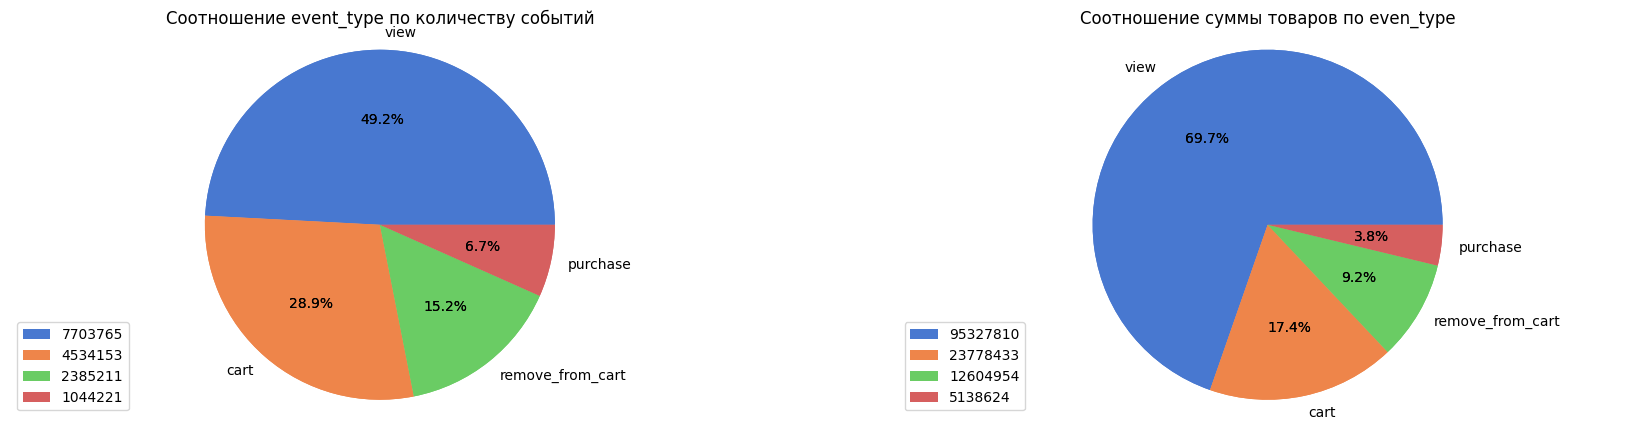

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(21,5)

labels = df_summ['event_type']
colors = sns.color_palette("muted")  #('lightblue', 'pink', 'lightgreen', 'lightgrey', 'mediumseagreen')

#  по кол-ву событий
sizes = df_summ['count_events']

axes[0].pie(sizes, colors = colors, labels = labels, autopct = '%1.1f%%')
patches, text, auto = axes[0].pie(sizes, colors = colors, autopct = '%1.1f%%')
axes[0].axis ('equal')
axes[0].legend (patches, sizes, loc = "lower left")
axes[0].set(title = "Соотношение event_type по количеству событий")

#по цене
sizes1 = df_summ['price'].astype(int)

axes[1].pie(sizes1, colors = colors, labels = labels, autopct = '%1.1f%%')
patches, text, auto = axes[1].pie(sizes1, colors = colors, autopct = '%1.1f%%')
axes[1].axis ('equal')
axes[1].legend (patches, sizes1, loc = "lower left")
axes[1].set(title = "Соотношение суммы товаров по even_type")

**Если предположить, что все пользователи сначала смотрят товар, потом добавляют в корзину, а потом покупают, то можно составить конверсионную воорнку** Для этой цели уникальным идентификаором будет связка user_id, user_session. Event_type "remove from cart" убираем из последовательности


In [ ]:
'''
funnel = df[df['event_type'].isin(['cart', 'purchase', 'view'])]['event_type'].value_counts().sort_values( ascending = False).reset_index()
for i in range(len(funnel)):
    if i == 0:
        funnel['percents'][i] = 1.00
    else:
        funnel['percents'][i] = (funnel['count'][i]/funnel['count'][i-1]).astype('float64')
funnel
'''

"\nfor i in range(len(funnel)):\n    if i == 0:\n        funnel['percents'][i] = 1.00\n    else:\n        funnel['percents'][i] = (funnel['count'][i]/funnel['count'][i-1]).astype('float64')\nfunnel\n"

In [ ]:
funnel = df[df['event_type'].isin(['cart', 'purchase', 'view'])].groupby('event_type')['user_session'].nunique().sort_values( ascending = False).reset_index()
funnel['prev_count'] = funnel['user_session'].shift(1)
funnel['percentage'] = funnel['user_session']*100/funnel['prev_count']
funnel[['event_type', 'user_session','percentage']]

,event_type,user_session,percentage
0,view,3411144,NaN
1,cart,800290,23.461044
2,purchase,126503,15.807145


**Сколько сессий приходиться на 1 пользователя: всего и завершившихся покупкой**

In [ ]:
print("Сессий на 1 пользователя: ", df['user_session'].nunique()/df['user_id'].nunique(), '\n',
      "Сессий с покупками на 1 пользователя: ", df[df['event_type']=="purchase"]['user_session'].nunique()/df[df['event_type']=="purchase"]['user_id'].nunique())

Сессий на 1 пользователя:  2.694542448410323 
 Сессий с покупками на 1 пользователя:  1.3653563873418815


In [ ]:
'''
for i in range(len(df_test)):
    if i ==0:
        df_test['test'][i] = 100
    else:
        df_test['test'][i] = df_test['price'][i]/df_test['price'][i-1]
df_test
'''

In [ ]:
((df['brand'].value_counts().nlargest(16))/1000).reset_index().rename(columns = {"count":"count, K"})

,brand,"count,K"
0,no_brand_data,6558.078
1,runail,1177.474
2,irisk,747.512
3,masura,660.852
4,grattol,652.597
5,bpw.style,359.661
6,ingarden,315.240
7,estel,274.805
8,kapous,256.192
9,jessnail,199.582


<Axes: title={'center': 'brand counts, K'}>

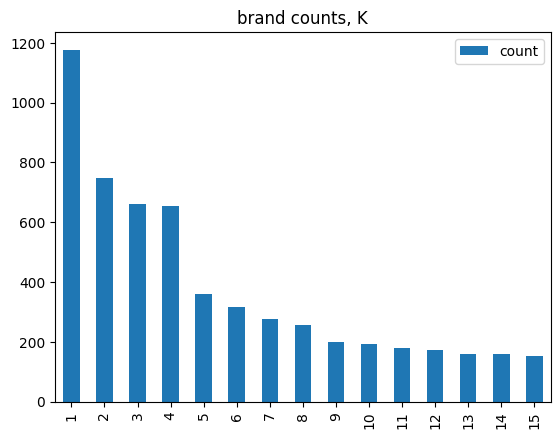

In [ ]:
((df['brand'].value_counts().nlargest(16))/1000).reset_index()[1::].plot(kind="bar", title="brand counts, K")

In [ ]:
#df[df['product_id']==5773203]['price'].sum()/df[df['product_id']==5773203]['price'].count()

np.float64(2.5129921259842525)

<Axes: xlabel='product_id', ylabel='price'>

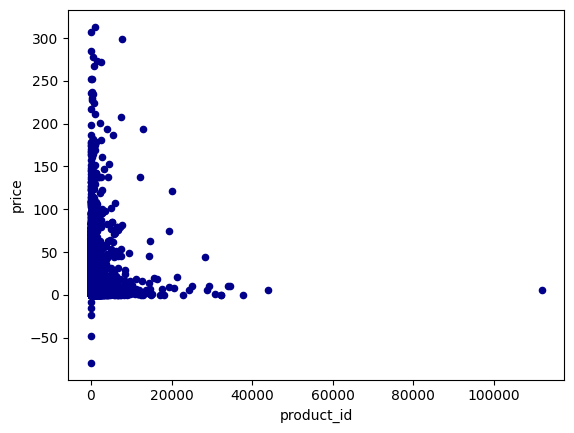

In [ ]:
df[['product_id', 'price']].groupby(['product_id']).agg({"product_id":"count", "price":"mean"}).plot.scatter(x='product_id', y = 'price', c = "darkblue")

In [ ]:
df['month_year'] = df['event_time'].dt.to_period('M')
month_summary = df.groupby(['month_year']).agg({"price":"sum", "product_id":"count", "user_id":"nunique"})
month_summary['product_per_user'] = month_summary['product_id']/month_summary['user_id']
month_summary['purchase_per_user, curr'] = month_summary['price']/month_summary['user_id']
month_summary.rename(columns = {"price": "Sales, currency", "product_id":"Sales, units", "user_id":"Uniq.Users"})

<ipython-input-8-6b0dccee0a5a>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month_year'] = df['event_time'].dt.to_period('M')


,"Sales, currency","Sales, units",Uniq.Users,product_per_user,"purchase_per_user, curr"
month_year,,,,,
2019-10,33934008.49,3889128,399664,9.730994,84.906343
2019-11,36468120.52,4389144,368232,11.919507,99.035718
2019-12,30417894.36,3349426,370154,9.048736,82.176322
2020-01,36029799.54,4039652,410073,9.851056,87.861916


In [ ]:
print(f"Кол-во уникальных пользователей {df['user_id'].nunique()}")

Кол-во уникальных пользователей 1341499


In [ ]:
df['date'] = df['event_time'].dt.round('D') #dt.date
daily_summary = df[df['event_type']=="purchase"].groupby(['date']).agg({"price":"sum", "product_id":"count", "user_id":"nunique"})
daily_summary['product_per_user'] = daily_summary['product_id']/daily_summary['user_id']
daily_summary['sales_per_user'] = daily_summary['price']/daily_summary['user_id']

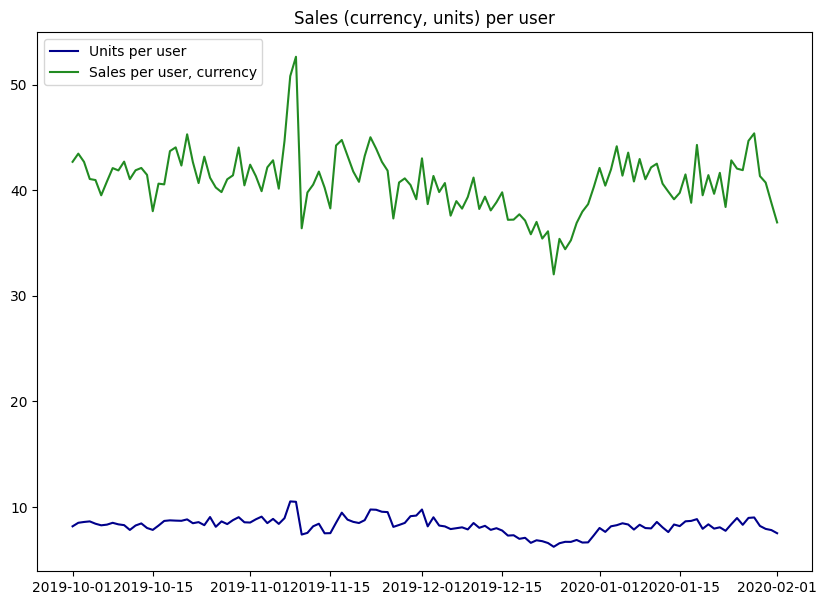

In [ ]:
plt.figure(figsize=(10,7))
plt.plot('date', 'product_per_user', data = daily_summary.reset_index()[['date', 'product_per_user']], c = "darkblue", label ="Units per user")
plt.plot('date', 'sales_per_user', data = daily_summary.reset_index()[['date', 'sales_per_user']], c = "forestgreen", label = "Sales per user, currency")
plt.title("Sales (currency, units) per user")
plt.legend(loc = 'upper left')
plt.show()


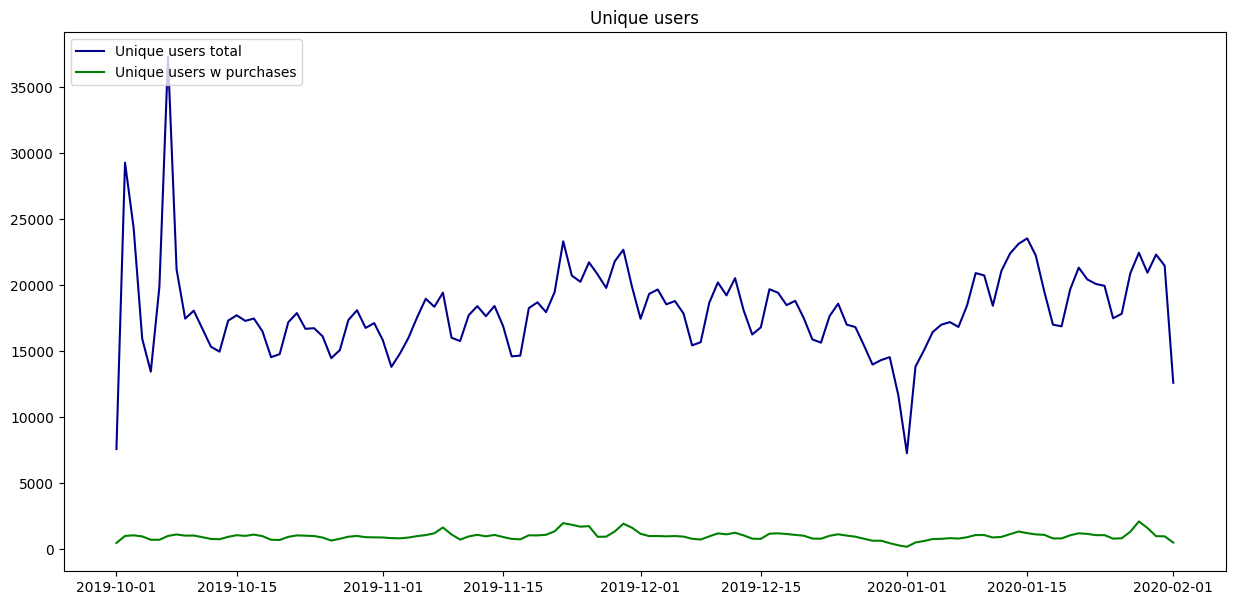

In [ ]:
plt.figure(figsize=(15,7))
plt.plot('date', 'user_id', data = df.groupby('date')['user_id'].nunique().reset_index(), c = "darkblue", label ="Unique users total")
plt.plot('date', 'user_id', data = df[df['event_type']=="purchase"].groupby('date')['user_id'].nunique().reset_index(), c = "green", label ="Unique users w purchases")
plt.title("Unique users")
plt.legend(loc = 'upper left')
plt.show()

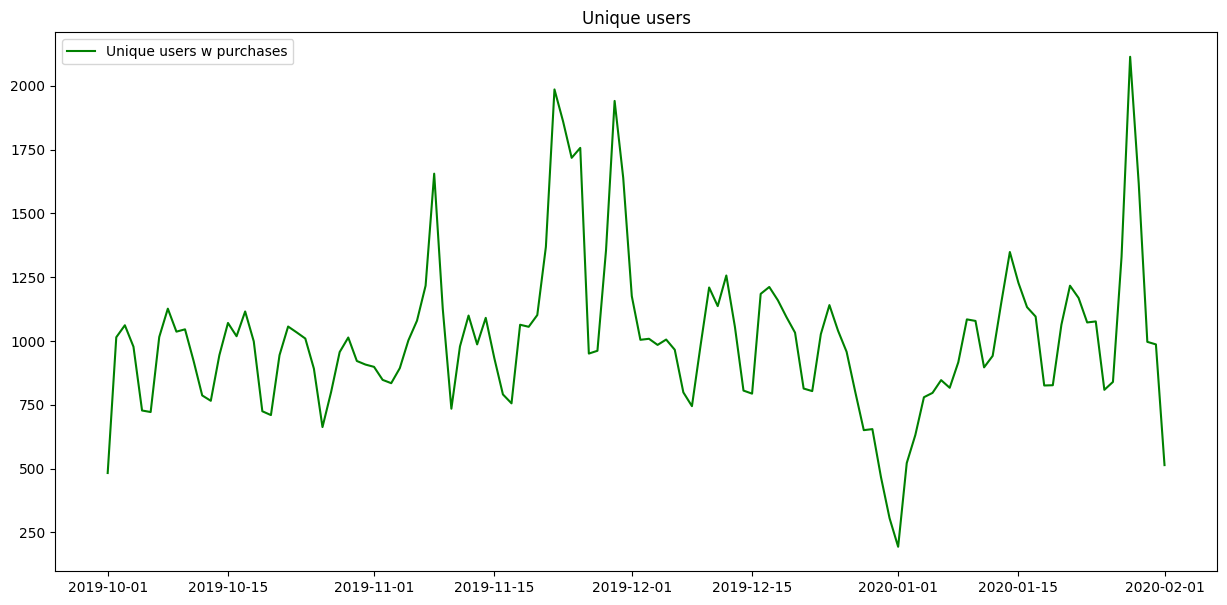

In [ ]:
plt.figure(figsize=(15,7))
plt.plot('date', 'user_id', data = df[df['event_type']=="purchase"].groupby('date')['user_id'].nunique().reset_index(), c = "green", label ="Unique users w purchases")
plt.title("Unique users")
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
df['day_of_week'] = df['date'].dt.dayofweek + 1

In [ ]:
dayofweek_names = dict({1: "Monday",
                         2: "Tuesday",
                         3: "Wednesday" ,
                         4: "Thursday",
                         5: "Friday",
                         6: "Saturday",
                         7: "Sunday"})

In [ ]:
df['Day_names'] = df['day_of_week'].map(dayofweek_names)
df = df.sort_values(by = 'date', ascending = True)

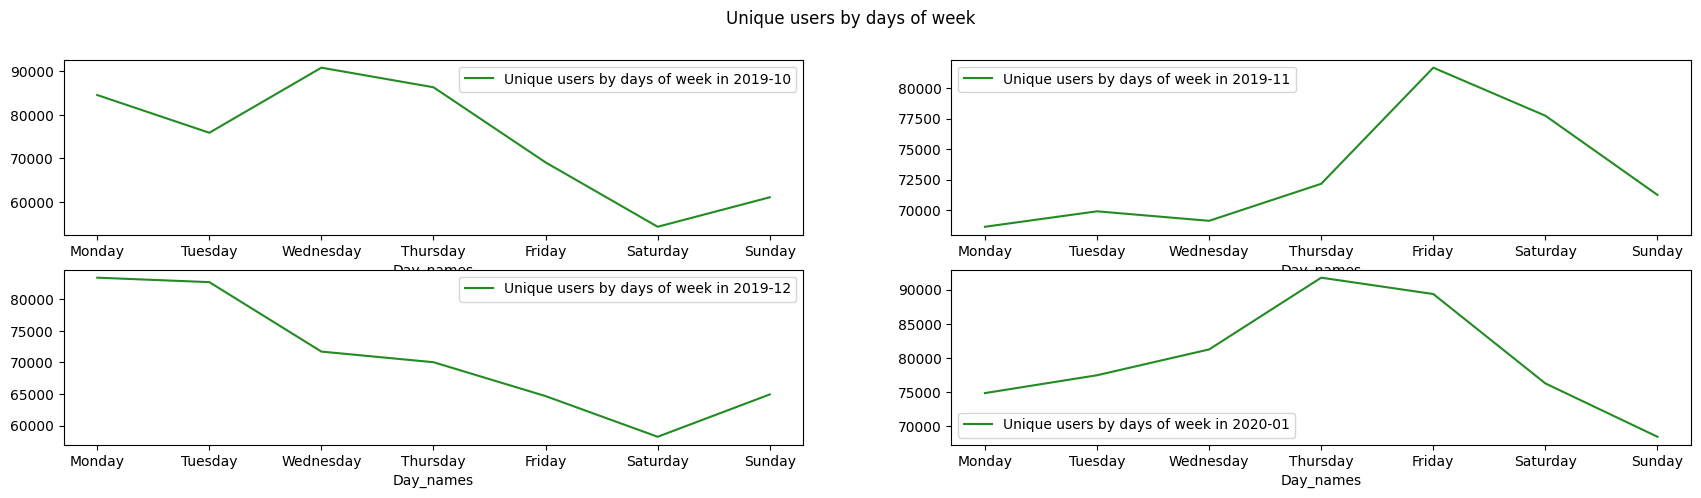

In [ ]:
#fig, axes = plt.subplots(2,2)
#fig.set_size_inches(21,5)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(21, 5))

for idx,i in enumerate(list(df['month_year'].unique())):
    df[df['month_year']==i].groupby(['Day_names', 'day_of_week'])['user_id'].nunique().reset_index().sort_values(by = 'day_of_week').plot(
                                                                                        'Day_names', 'user_id',
                                                                                         subplots=True,
                                                                                         kind="line",
                                                                                         title = (f"Unique users by days of week"),
                                                                                         color = "forestgreen",
                                                                                         label = f"Unique users by days of week in {i}",
                                                                                         ax=axes[idx // 2, idx % 2] )

### Когортный, RFM в Colab

#### Когортный
Разобью на когорты по неделе первой покупки. Самую ранню дату в датасете будем считать датой первой покупки. Рассматриваю 2019 год.

In [ ]:
'''
df['week_num'] = df['date'].dt.year.astype('str') +"-"+ df['date'].dt.isocalendar().week.astype('str')
df['cohort'] = df.groupby('user_id')['date'].transform('min').dt.year.astype('str') +"-"+ df.groupby('user_id')['date'].transform('min').dt.isocalendar().week.astype('str')
df['cohort']
'''

In [ ]:
# df загрузить из BQ
purchased = df[(df['event_type']=="purchase") & (df['price']>0)]

In [ ]:
purchased['date'] = pd.to_datetime(purchased['event_time'].dt.date)

In [ ]:
purchased.head()

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session,date
729,purchase,2020-01-12 03:02:19+00:00,4923,1487580010695884882,no_brand_data,69.05,599956793,dc240f9e-8d8d-49e2-b62f-5ab92f46e7ec,2020-01-12
730,purchase,2019-12-01 12:26:32+00:00,5261,1487580009605365797,runail,0.40,578508619,0595ad6d-1a0c-4b2a-b6e0-762ea1c3d6b6,2019-12-01
731,purchase,2019-10-09 13:37:11+00:00,6818,1487580013027917999,no_brand_data,1.51,555238101,4343ae0c-5030-4843-a930-3fd781aac5a2,2019-10-09
732,purchase,2020-01-27 09:49:29+00:00,6938,1487580007936033754,runail,2.14,605052955,72b26455-1412-4c87-b70f-0fa8e6b5be6f,2020-01-27
733,purchase,2019-12-04 09:59:35+00:00,36407,1487580009672474664,balbcare,3.17,449317470,892465a7-84b8-4574-be31-f9549bf440d4,2019-12-04


In [ ]:
purchased['week_num'] = purchased['date'].dt.isocalendar().week
purchased['cohort'] = purchased.groupby('user_id')['date'].transform('min').dt.isocalendar().week
purchased['cohort_year'] = purchased.groupby('user_id')['date'].transform('min').dt.year

In [ ]:
purchased['year'] = purchased['date'].dt.year
purchased = purchased[purchased['year'] == 2019]
purchased['week_num'] = np.where((purchased['week_num'] == 1), 52, purchased['week_num'])
purchased['cohort'] = np.where(((purchased['cohort'] == 1) & (purchased['cohort_year'] == 2019)), 52, purchased['cohort'])

In [ ]:
#проверка
#purchased[purchased['cohort'] =='2019-52']['date'].min()
purchased[purchased['month_year'] == '2019-12'].sample(5)

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session,date,week_num,cohort,cohort_year,month_year
5602245,purchase,2019-12-08 17:55:36+00:00,5864737,2055161088059638328,bpw.style,1.59,563183288,eb5cf2bb-6abf-4037-9c42-5e3b5e49cd10,2019-12-08,49,49,2019,2019-12
3069918,purchase,2019-12-06 08:14:47+00:00,5624537,1487580012809814181,masura,6.97,470877727,13fe9236-e2b9-4513-a009-c0abc80bde27,2019-12-06,49,41,2019,2019-12
10648159,purchase,2019-12-11 10:05:07+00:00,5903984,1487580007675986893,no_brand_data,1.59,585222445,a962fea6-1069-40ad-8622-1ea0ab25d005,2019-12-11,50,50,2019,2019-12
7706635,purchase,2019-12-02 23:26:18+00:00,5801339,1487580005511725929,no_brand_data,6.35,484207396,4bf158c0-863b-443d-a381-cf1c60ad75d4,2019-12-02,49,41,2019,2019-12
4626936,purchase,2019-12-30 11:07:37+00:00,5774328,1783999064103190764,runail,3.81,561079561,f24f6c58-cee4-4514-89dd-db702abdba1b,2019-12-30,52,52,2019,2019-12


In [ ]:
# проверка
purchased[(purchased['cohort'] == 52) & (purchased['date'] == '2019-12-30')].sample(5)

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session,month_year,date,day_of_week,Day_names,week_num,cohort,cohort_year
9853873,purchase,2019-12-30 04:41:19+00:00,5695546,1487580006317032337,no_brand_data,1.59,540972653,e3339042-9e46-4341-abb7-d6a4644226eb,2019-12,2019-12-30 00:00:00+00:00,1,Monday,52,52,2019
12486833,purchase,2019-12-30 08:08:10+00:00,5700037,1487580009286598681,runail,0.40,585264538,71667f56-f0d2-4586-8d8d-f139dbabadcf,2019-12,2019-12-30 00:00:00+00:00,1,Monday,52,52,2019
14222970,purchase,2019-12-30 11:17:30+00:00,5809910,1602943681873052386,grattol,5.24,588228097,8216e498-68b6-c15a-0415-89a5e4fd4d4a,2019-12,2019-12-30 00:00:00+00:00,1,Monday,52,52,2019
2255733,purchase,2019-12-30 10:01:32+00:00,5723409,1487580012927254698,no_brand_data,14.29,555614235,07c52c66-c793-433c-8bef-bf7daf3784dc,2019-12,2019-12-30 00:00:00+00:00,1,Monday,52,52,2019
8272200,purchase,2019-12-30 10:43:50+00:00,5687130,1487580008187692007,no_brand_data,0.79,594732809,cd728933-bddf-4cee-8cfe-bb48da6bfdcc,2019-12,2019-12-30 00:00:00+00:00,1,Monday,52,52,2019


In [ ]:
purchased.groupby('week_num')['user_id'].nunique()

,user_id
week_num,
40,5412
41,6459
42,6401
43,6238
44,6186
45,7444
46,6510
47,10494
48,8622


In [ ]:
purchased[purchased['week_num']==4]

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session,date,week_num,cohort,cohort_year,month_year
758,purchase,2020-01-26 16:39:48+00:00,5889300,1487580007306888126,no_brand_data,3.33,605754218,e77d7055-ce2b-42df-9c48-df184dc6cbf5,2020-01-26,4,4,2020,2020-01
2994,purchase,2020-01-21 08:30:18+00:00,5903598,1487580011627020412,naomi,2.78,604054530,56512970-90e4-42cf-845e-81b6cdc1709a,2020-01-21,4,4,2020,2020-01
10258,purchase,2020-01-21 06:10:11+00:00,5702043,2140803113261466607,irisk,1.27,508843109,b0828a92-3828-4073-ac90-e6569d7af861,2020-01-21,4,41,2019,2020-01
10266,purchase,2020-01-24 17:08:52+00:00,5834157,1487580013506068678,runail,5.71,591934228,1d571025-72c1-4ef8-bb8b-14bf01561e00,2020-01-24,4,52,2019,2020-01
11641,purchase,2020-01-21 10:37:07+00:00,5686977,1487580008187692007,no_brand_data,3.02,394881572,52d5e6a8-b721-472e-b18c-5b15f4eaac53,2020-01-21,4,4,2020,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15666527,purchase,2020-01-26 19:16:30+00:00,5798931,1783999068909863670,zinger,6.19,406028684,93526288-80db-4185-b761-bdc0acb36616,2020-01-26,4,48,2019,2020-01
15666614,purchase,2020-01-26 22:58:32+00:00,5808174,1487580009445982239,zinger,1.19,593302927,45130c89-24f1-4f4c-94df-98c68b137c54,2020-01-26,4,3,2020,2020-01
15666832,purchase,2020-01-24 11:56:13+00:00,5798928,1783999068909863670,zinger,6.19,604169323,e545aaa5-7c5e-4a3d-b14c-3444c5922bb2,2020-01-24,4,4,2020,2020-01
15667122,purchase,2020-01-21 14:35:46+00:00,5798929,1783999068909863670,zinger,6.19,565614943,3c21704d-05f5-42ad-89c7-edf3acf64cbd,2020-01-21,4,4,2020,2020-01


In [ ]:
purchased['period_num'] = (purchased.week_num - purchased.cohort)   #.apply(attrgetter('n'))
df_cohort = purchased[purchased['date']<='2019-12-31'].groupby(['cohort', 'period_num']).agg(n_accounts = ('user_id', 'nunique')).reset_index(drop= False)

In [ ]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_num',
                                     values = 'n_accounts')

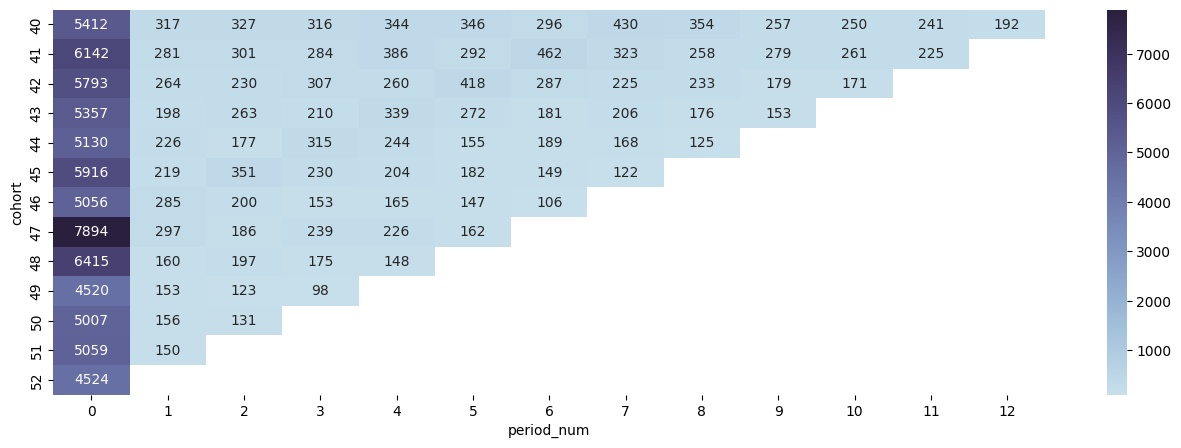

In [ ]:
plt.figure(figsize = (16,5))
sns.heatmap(cohort_pivot, annot = True, fmt = 'g',
            cmap = sns.color_palette("ch:s=.25, rot=-.25", as_cmap = True))
plt.show()

#### Ретеншн

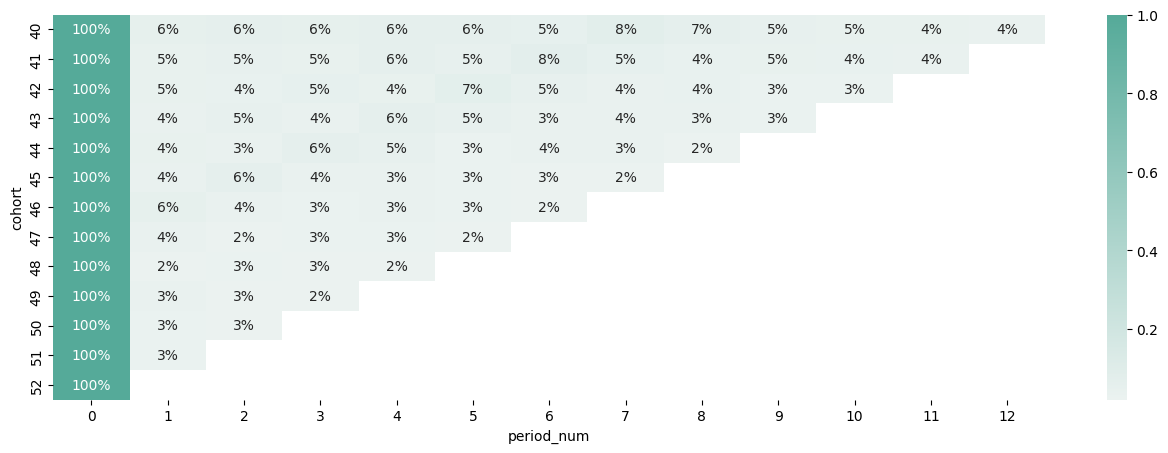

In [ ]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
plt.figure(figsize=(16,5))
sns.heatmap (retention_matrix, fmt = '.0%', annot = True,
             cmap = (sns.color_palette("light:#5A9", as_cmap = True)) )
plt.show()

In [ ]:
cohort_size.describe()

,0
count,13.000000
mean,5555.769231
std,908.837733
min,4520.000000
25%,5056.000000
50%,5357.000000
75%,5916.000000
max,7894.000000


#### RFM для клиентов

In [ ]:
rfm_raw = df[(df['price']>0) & (df['event_type']=="purchase")]

In [ ]:
rfm_raw['category_id'].nunique()

466

In [ ]:
purchased.head()

,event_type,product_id,category_id,brand,price,user_id,user_session,month_year,date,day_of_week,Day_names,year,month
1299101,purchase,5848909,1487580007675986893,bpw.style,0.79,443619878,9755eb3c-13bc-4a3d-8175-be7b621686a1,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,2019,10
14897907,purchase,5815657,1487580006317032337,no_brand_data,0.67,477088551,ea107e7f-0985-4883-8e59-e2e0a88ac460,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,2019,10
543637,purchase,5856296,1658462125284131265,uskusi,3.81,437337996,3b5a4958-4599-7eee-c491-63603c09db8a,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,2019,10
7732353,purchase,5754899,1487580005092295511,no_brand_data,4.76,537432414,4614f29c-02f7-4c76-98e6-a746f2178e66,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,2019,10
7358532,purchase,5880381,2018395024110125980,no_brand_data,9.84,517517050,529f0f9b-0042-44a6-b4ca-9607c5acca6c,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,2019,10


In [ ]:
purchased['year'] = purchased['date'].dt.year
purchased['month'] = purchased['date'].dt.month
purchased = purchased.drop('event_time', axis = 1)

**Revenue = Monetary**


In [ ]:
rfm_m = pd.DataFrame(purchased.groupby([purchased.year, purchased.month])['price'].sum()).rename(columns={"price":"Revenue"})

In [ ]:
rfm_m['MonthlyGrowth'] = rfm_m['Revenue'].pct_change()
rfm_m.head()

Revenue  MonthlyGrowth
year month                           
2019 10     1188589.74            NaN
     11     1514146.74       0.273902
     12     1112325.02      -0.265378
2020 1      1304566.09       0.172828
     2        18996.43      -0.985439

In [ ]:
rfm_m['ActiveCustomers'] = pd.DataFrame(purchased.groupby([purchased.year,purchased.month])['user_id'].nunique())
rfm_m

Revenue  MonthlyGrowth  ActiveCustomers
year month                                            
2019 10     1188589.74            NaN            25351
     11     1514146.74       0.273902            31177
     12     1112325.02      -0.265378            26324
2020 1      1304566.09       0.172828            27850
     2        18996.43      -0.985439              514

In [ ]:
rfm_m['MonthlyOrderCount'] = pd.DataFrame(purchased.groupby([purchased.year,purchased.month])['user_session'].nunique())
rfm_m

Revenue  MonthlyGrowth  ActiveCustomers  MonthlyOrderCount
year month                                                               
2019 10     1188589.74            NaN            25351              28820
     11     1514146.74       0.273902            31177              36155
     12     1112325.02      -0.265378            26324              29736
2020 1      1304566.09       0.172828            27850              31947
     2        18996.43      -0.985439              514                523

In [ ]:
purchased1 = purchased.groupby(['year','month','user_session'])['price'].sum().reset_index()
rfm_m['MonthlyOrderAverage'] =  pd.DataFrame(purchased1.groupby([purchased1.year,purchased1.month])['price'].mean())
rfm_m

Revenue  MonthlyGrowth  ActiveCustomers  MonthlyOrderCount  \
year month                                                                  
2019 10     1188589.74            NaN            25351              28820   
     11     1514146.74       0.273902            31177              36155   
     12     1112325.02      -0.265378            26324              29736   
2020 1      1304566.09       0.172828            27850              31947   
     2        18996.43      -0.985439              514                523   

            MonthlyOrderAverage  
year month                       
2019 10               41.241837  
     11               41.879318  
     12               37.406679  
2020 1                40.835324  
     2                36.322046

In [ ]:
# показываем индекс, чтобы было видно месяц и год
rfm_m.index.set_names(['Year', 'Month'], inplace = True)
rfm_m

Revenue  MonthlyGrowth  ActiveCustomers  MonthlyOrderCount  \
Year Month                                                                  
2019 10     1188589.74            NaN            25351              28820   
     11     1514146.74       0.273902            31177              36155   
     12     1112325.02      -0.265378            26324              29736   
2020 1      1304566.09       0.172828            27850              31947   
     2        18996.43      -0.985439              514                523   

            MonthlyOrderAverage  
Year Month                       
2019 10               41.241837  
     11               41.879318  
     12               37.406679  
2020 1                40.835324  
     2                36.322046

In [ ]:
rfm_m.index

MultiIndex([(2019, 10),
            (2019, 11),
            (2019, 12),
            (2020,  1),
            (2020,  2)],
           names=['Year', 'Month'])

**Делаем дата-фрейм с первой покупкой покупателя**

In [ ]:
customer_fist_purchase = purchased.groupby('user_id')['date'].min().reset_index()

customer_fist_purchase.columns = ['user_id','FirstPurchaseDate']

customer_fist_purchase['FirstPurchaseYearMonth'] = customer_fist_purchase['FirstPurchaseDate'].map(lambda date: 100*date.year+date.month)
customer_fist_purchase

,user_id,FirstPurchaseDate,FirstPurchaseYearMonth
0,9794320,2019-11-25 00:00:00+00:00,201911
1,10079204,2019-11-06 00:00:00+00:00,201911
2,10280338,2019-11-21 00:00:00+00:00,201911
3,12055855,2019-12-21 00:00:00+00:00,201912
4,12936739,2020-01-17 00:00:00+00:00,202001
...,...,...,...
92647,608807757,2020-02-01 00:00:00+00:00,202002
92648,608809325,2020-02-01 00:00:00+00:00,202002
92649,608809552,2020-02-01 00:00:00+00:00,202002
92650,608812129,2020-02-01 00:00:00+00:00,202002


In [ ]:
#Складываем две таблицы - с первой покупкой и основную
purchased_1stpurch = pd.merge(purchased, customer_fist_purchase, on='user_id')
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html

purchased_1stpurch.head()

,event_type,product_id,category_id,brand,price,user_id,user_session,month_year,date,day_of_week,Day_names,week_num,cohort,cohort_year,year,month,FirstPurchaseDate,FirstPurchaseYearMonth
0,purchase,5864600,1487580013011140782,italwax,1.24,429179215,125c71ea-435a-4ef3-9df8-bdcfad1c46a3,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,40,40,2019,2019,10,2019-10-01 00:00:00+00:00,201910
1,purchase,5855743,1783999067156644376,skipofit,6.19,550785782,134671af-1eb5-4413-a48a-01213ea6fa59,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,40,40,2019,2019,10,2019-10-01 00:00:00+00:00,201910
2,purchase,5700037,1487580009286598681,runail,0.40,543446752,4a01cad9-7368-fd9e-d907-d4d85de0b55c,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,40,40,2019,2019,10,2019-10-01 00:00:00+00:00,201910
3,purchase,5846456,2151191071378375538,browxenna,15.40,549314316,d9a15a3a-d58f-4b15-bae4-ecbe272dfa4d,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,40,40,2019,2019,10,2019-10-01 00:00:00+00:00,201910
4,purchase,5875549,2084144451428549153,no_brand_data,2.05,433079764,ad62c7d5-66f0-6b02-bce9-77be74deac5f,2019-10,2019-10-01 00:00:00+00:00,2,Tuesday,40,40,2019,2019,10,2019-10-01 00:00:00+00:00,201910


In [ ]:
#Создаем новую колонку - пока по дефолту все пользователи - New
purchased_1stpurch['UserType'] = 'New'
#Создаем колонку ['YearMonth'] в нужном формате
purchased_1stpurch['YearMonth'] = purchased_1stpurch['date'].map(lambda date: 100*date.year + date.month)

In [ ]:
#Теперь мы можем добавить пользователей с другим статусом!
purchased_1stpurch.loc[purchased_1stpurch['YearMonth'] > purchased_1stpurch['FirstPurchaseYearMonth'],'UserType'] = 'Existing'

In [ ]:
#Считаем Revenue для каждого типа пользователя
customer_kpis = pd.DataFrame(purchased_1stpurch.groupby([purchased_1stpurch.year,purchased_1stpurch.month, purchased_1stpurch.UserType])['price'].sum())
customer_kpis.index.set_names(['Year', 'Month', 'UserType'], inplace = True)
customer_kpis

price
Year Month UserType            
2019 10    New       1188589.74
     11    Existing   314794.79
           New       1199351.95
     12    Existing   319027.80
           New        793297.22
2020 1     Existing   450711.29
           New        853854.80
     2     Existing     7240.40
           New         11756.03

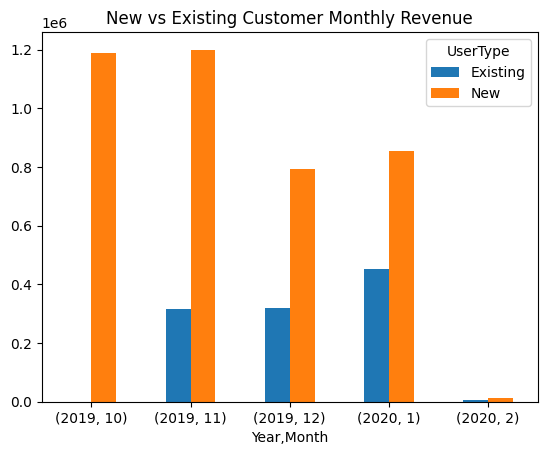

In [ ]:
#Сравниваем новых и вернувшихся
customer_kpis.unstack().plot.bar(y='price', title='New vs Existing Customer Monthly Revenue', rot=0);

In [ ]:
#Создаем новый дата-фрейм основываясь на user_id
customer = pd.DataFrame(purchased['user_id'].unique())
customer.columns = ['user_id']

#Последняя дата сессии date.max()
recency = purchased_1stpurch.groupby('user_id').date.max().reset_index()
recency.columns = ['user_id','LastPurchaseDate']

# Максимальное значение (самая свежая покупка)
LastInvoiceDate = recency['LastPurchaseDate'].max()

# Новизна покупки для каждого покупателя по сравнениею с LastInvoiceDate
recency['Recency'] = (LastInvoiceDate - recency['LastPurchaseDate']).dt.days
customer = pd.merge(customer, recency[['user_id','Recency']], on='user_id')

# Считаем количество сессий на каждого покупателя
frequency = purchased_1stpurch.groupby('user_id').user_session.count().reset_index()
frequency.columns = ['user_id','Frequency']
customer = pd.merge(customer, frequency, on='user_id')

# Группируем выручку по покупателю
revenue =  purchased_1stpurch.groupby('user_id').price.sum().reset_index()
revenue.columns = ['user_id', 'Monetary']
customer = pd.merge(customer, revenue, on='user_id')

customer.head()


,user_id,Recency,Frequency,Monetary
0,429179215,3,4,254.57
1,550785782,122,2,20.15
2,543446752,123,1,105.38
3,549314316,123,1,15.40
4,433079764,20,32,639.09


In [ ]:
recency.describe()

,user_id,Recency
count,92652.0,92652.000000
mean,521275950.280588,56.216153
std,86857230.702277,35.622387
min,9794320.0,0.000000
25%,486131335.75,23.000000
50%,556592167.5,57.000000
75%,577254596.25,85.000000
max,608817151.0,123.000000


In [ ]:
customer.sort_values('Monetary', ascending = False) #сортируем
customer["Monetary"] = customer["Monetary"].astype(int) #приводим к int виду

**Разделим датасет на 5 частей**

In [ ]:
customer['Recency_group'] = pd.qcut(customer.Recency.sort_values(ascending = False), q=5, labels = ['1','2','3','4','5'][::-1])
customer['Frequency_group'] = pd.qcut(customer.Frequency.rank(method='first'), q=5, labels = ['1','2','3','4','5'], duplicates = 'raise')                              #, ordered = True)
customer['Monetary_group'] = pd.qcut(customer.Monetary.sort_values(ascending = True), q=5, labels = ['1','2','3','4','5'])                                             #, ordered = True)
customer['RFM'] = customer['Recency_group'].astype(str) + customer['Frequency_group'].astype(str) + customer['Monetary_group'].astype(str)
customer.head()

,user_id,Recency,Frequency,Monetary,Recency_group,Frequency_group,Monetary_group,RFM
0,429179215,3,4,254.57,5,5,5,555
1,550785782,122,2,20.15,1,4,2,142
2,543446752,123,1,105.38,1,1,5,115
3,549314316,123,1,15.40,1,1,2,112
4,433079764,20,32,639.09,4,5,5,455


### Нейросеть для пояснений по RFM (Giga chat)

In [ ]:
from google.colab import userdata
auth = userdata.get('auth')

import requests
import uuid
import json

In [ ]:
#import requests
#import uuid

def get_token (auth_token, scope = 'GIGACHAT_API_PERS'):
    rq_uid = str(uuid.uuid4())
    #API url:
    url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"
    # Заголовки
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Accept': 'application/json',
        'RqUID': rq_uid,
        'Authorization': f'Basic {auth_token}'
    }
    payload = {
        'scope': scope
    }

    try:
        response = requests.post(url, headers = headers, data = payload, verify = False) # False т.к. Минцифры нет
        return response
    except requests.RequestException as e:
        print (f'Ошибка: {str(e)}')
        return -1

# получение токена доступа

response = get_token(auth)
if response !=1:
      print(response.text)
      giga_token = response.json()['access_token']


# Получение перечня моделей
# url с сайта gigachat для получения перечня моделей

url = "https://gigachat.devices.sberbank.ru/api/v1/models"

payload = {}
headers = {
      'Accept': 'application/json',
      'Authorization': f'Bearer {giga_token}'
}
response = requests.request("GET", url, headers=headers, data=payload, verify = False)
#print (response.text)


def get_chat_completion (auth_token, user_message):
    url = 'https://gigachat.devices.sberbank.ru/api/v1/chat/completions'
    payload = json.dumps ({
        "model": "GigaChat-Max",
        "messages": [
            {
              "role": "user",
              "content": user_message
            }
          ],
          "temperature": 1,
          "top_p": 0.1,
          "n": 1,
          "stream": False,
          "max_tokens": 512,
          "repetition_penalty": 1,
          "update_interval": 0
    })
    headers = {
        'Content-Type': 'application/json',
        'Accept': 'application/json',
        'Authorization': f'Bearer {auth_token}'
    }
    try:
          response = requests.request("POST", url, headers = headers, data = payload, verify = False) # False т.к. Минцифры нет
          return response
    except requests.RequestException as e:
        print (f'Ошибка: {str(e)}')
        return -1

In [ ]:
import warnings
warnings.filterwarnings('ignore')

while True:
    req = input("Введите запрос (Пример запроса по RFM: RFM данные разбиты на 5 групп. Что означает группа 555?) ")
    print("----------------------------------------------------------------------------------------------------------------------")
    answer = get_chat_completion(giga_token, req).json()['choices'][0]['message']['content']
    print(answer)
    print("-----------------------------------------------------------------------------------------------------------------------")
    req2 = input("Хотите что-то еще уточнить? Да / Нет ")
    if str.lower(req2) == "да":
        req
    else:
        break

Введите запрос (Пример запроса по RFM: RFM данные разбиты на 5 групп. Что означает группа 555?) RFM данные разбиты на 5 групп. Что означает группа 555?
----------------------------------------------------------------------------------------------------------------------
RFM-анализ — это метод сегментации клиентов, основанный на трёх ключевых показателях: Recency (давность последней покупки), Frequency (частота покупок) и Monetary (сумма покупок). Каждый из этих показателей делится на несколько групп (обычно от 1 до 5), где 1 — худший показатель, а 5 — лучший.

Если RFM данные разбиты на 5 групп, то группа 555 означает:

- **Recency (R)**: Клиент недавно совершил покупку (наиболее недавняя активность).
- **Frequency (F)**: Клиент часто совершает покупки (высокая частота).
- **Monetary (M)**: Клиент тратит много денег (высокий средний чек).

Таким образом, группа 555 — это наиболее ценные клиенты, которые активно и часто совершают покупки, принося компании наибольшую прибыль.
-----------

### ML  BQ

In [ ]:
# сделаю представление сгруппированных для ML данных. Буду рогнозировать кол-ва или суммы покупок в грануляции дней.
# прогноз будет на январь 2020.

%%bigquery --project $PROJECT_ID

CREATE OR REPLACE VIEW `guzel-2021-a9e57.TermPaper.ecom_cosmetics_grouped_ML` as (
SELECT
  date_trunc(`event_time`, day) as Date,
  count(`category_id`) as Category_qty,
  sum(`price`) as Sales,
  count(`product_id`) as Products_qty,
  count(distinct `user_id`) as Customers,
  count(distinct `user_session`) as Sessions
FROM
  `guzel-2021-a9e57.TermPaper.ecom_cosmetics_raw_data`
  where
  event_type = 'purchase'
  and `price` > 0
  group by 1);

In [ ]:
%%bigquery df_ml  --project $PROJECT_ID

SELECT
  Date,
  Category_qty,
  Sales,
  Products_qty,
  Customers,
  Sessions
FROM
  `guzel-2021-a9e57.TermPaper.ecom_cosmetics_grouped_ML`;

In [ ]:
df_ml.head()

,Date,Category_qty,Sales,Products_qty,Customers,Sessions
0,2019-11-10 00:00:00+00:00,6203,31488.65,6203,813,826
1,2019-11-13 00:00:00+00:00,8431,44406.47,8431,1092,1111
2,2019-12-24 00:00:00+00:00,6895,36817.22,6895,1083,1100
3,2019-12-01 00:00:00+00:00,7230,32686.73,7230,825,834
4,2019-11-29 00:00:00+00:00,17989,78179.16,17989,2002,2036


In [ ]:
# даты начала и окончания для обучающих данных
ARIMA_PARAMS = {
    'TRAININGDATA_STARTDATE': '2019-10-01',
    'TRAININGDATA_ENDDATE': '2019-12-31',
}
ARIMA_PARAMS

In [ ]:
%%bigquery df_ml_train --params $ARIMA_PARAMS  --project $PROJECT_ID

CREATE OR REPLACE TABLE TermPaper.training_data AS (
    SELECT
        Date,
        Customers
    FROM
        `guzel-2021-a9e57.TermPaper.ecom_cosmetics_grouped_ML`
    GROUP BY
        1, 2
    HAVING
        Date BETWEEN @TRAININGDATA_STARTDATE AND @TRAININGDATA_ENDDATE
    );

SELECT
     Date,
    Customers
FROM
     TermPaper.training_data
ORDER BY 1, 2

In [ ]:
df_ml_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       61 non-null     datetime64[ns, UTC]
 1   Customers  61 non-null     Int64              
dtypes: Int64(1), datetime64[ns, UTC](1)
memory usage: 1.1 KB


In [ ]:
df_ml_train.head()

,Date,Customers
0,2019-10-01 00:00:00+00:00,1001
1,2019-10-02 00:00:00+00:00,1045
2,2019-10-03 00:00:00+00:00,1048
3,2019-10-04 00:00:00+00:00,892
4,2019-10-05 00:00:00+00:00,708


In [ ]:
#создание модели

%%bigquery --project $PROJECT_ID

CREATE OR REPLACE MODEL TermPaper.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='Date',
  TIME_SERIES_DATA_COL='Customers',
  HOLIDAY_REGION='US'
) AS

SELECT
    Date,
    Customers
FROM
   TermPaper.training_data

In [ ]:
# оценка модели
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
  ML.EVALUATE(MODEL TermPaper.arima_model)

In [ ]:
# прогнозирование

%%bigquery df_ml_forecast --project $PROJECT_ID

DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.95";
# Выполняет динамическую инструкцию SQL на лету
EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM
       ML.FORECAST(MODEL TermPaper.arima_model,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)

In [ ]:
df_ml_forecast.head()

,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,2020-01-01 00:00:00+00:00,131.259286,166.546575,0.95,-194.582108,457.100679,-194.582108,457.100679
1,2020-01-02 00:00:00+00:00,783.253102,224.444024,0.95,344.137775,1222.368430,344.137775,1222.368430
2,2020-01-03 00:00:00+00:00,1041.597661,298.609100,0.95,457.381471,1625.813850,457.381471,1625.813850
3,2020-01-04 00:00:00+00:00,898.918088,306.792261,0.95,298.691886,1499.144290,298.691886,1499.144290
4,2020-01-05 00:00:00+00:00,903.437057,306.792261,0.95,303.210854,1503.663259,303.210854,1503.663259


In [ ]:
px.line(df_ml_forecast.sort_values(by=['forecast_timestamp'], ascending=[True]), x='forecast_timestamp', y='forecast_value')

In [ ]:
# коэффициенты модели
%%bigquery --project $PROJECT_ID

SELECT
  *
FROM
   ML.ARIMA_COEFFICIENTS(MODEL TS.arima_model)

In [ ]:
df_ml_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   forecast_timestamp               30 non-null     datetime64[ns, UTC]
 1   forecast_value                   30 non-null     float64            
 2   standard_error                   30 non-null     float64            
 3   confidence_level                 30 non-null     float64            
 4   prediction_interval_lower_bound  30 non-null     float64            
 5   prediction_interval_upper_bound  30 non-null     float64            
 6   confidence_interval_lower_bound  30 non-null     float64            
 7   confidence_interval_upper_bound  30 non-null     float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 2.0 KB


In [ ]:
%%bigquery df_ml_actual --params $ARIMA_PARAMS --project $PROJECT_ID

DECLARE HORIZON STRING DEFAULT "29"; #number of values to forecast

SELECT
    Date,
    Customers
FROM
    `guzel-2021-a9e57.TermPaper.ecom_cosmetics_grouped_ML`
GROUP BY
    1, 2
HAVING
    Date BETWEEN '2020-01-01' and '2020-01-29'
ORDER BY
   1

In [ ]:
df_ml_forecast[['forecast_timestamp',	'forecast_value']].rename(columns = {"forecast_timestamp": "Date"})

,Date,forecast_value
0,2020-01-01 00:00:00+00:00,131.259286
1,2020-01-02 00:00:00+00:00,783.253102
2,2020-01-03 00:00:00+00:00,1041.597661
3,2020-01-04 00:00:00+00:00,898.918088
4,2020-01-05 00:00:00+00:00,903.437057
5,2020-01-06 00:00:00+00:00,1003.142970
6,2020-01-07 00:00:00+00:00,998.185035
7,2020-01-08 00:00:00+00:00,979.276799
8,2020-01-09 00:00:00+00:00,1137.432751
9,2020-01-10 00:00:00+00:00,1090.520760


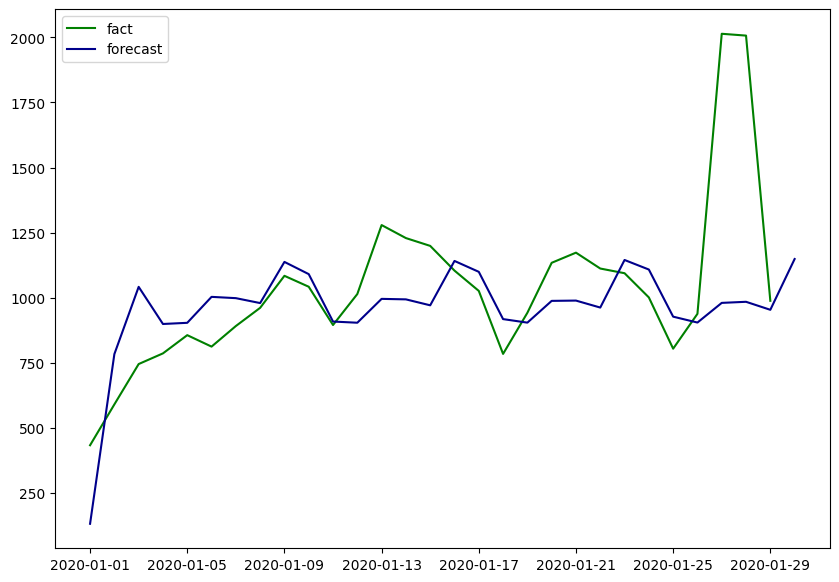

In [ ]:
plt.figure(figsize=(10,7))
plt.plot('Date', 'Customers', data = df_ml_actual, color = "green", label = 'fact')
plt.plot('forecast_timestamp', 'forecast_value', data = df_ml_forecast, color = "darkblue", label = "forecast")
plt.legend(loc = 'best')
plt.show()

In [ ]:
(df_ml_actual['Date']+pd.Timedelta(30, "d")).max(), df_ml_actual['Date'].max()

(Timestamp('2020-01-30 00:00:00+0000', tz='UTC'),
 Timestamp('2019-12-31 00:00:00+0000', tz='UTC'))

### ML в Colab

In [ ]:
# сначала загрузить датасет из BQ еще раз
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15667350 entries, 0 to 15667349
Data columns (total 8 columns):
 #   Column        Dtype              
---  ------        -----              
 0   event_type    object             
 1   event_time    datetime64[ns, UTC]
 2   product_id    Int64              
 3   category_id   Int64              
 4   brand         object             
 5   price         float64            
 6   user_id       Int64              
 7   user_session  object             
dtypes: Int64(3), datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 1001.1+ MB


In [ ]:
df_ml_colab = df.copy(deep=True)

In [ ]:
df.head()

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session
0,remove_from_cart,2019-10-25 20:32:50+00:00,5753818,1487580005008409427,f.o.x,4.22,352481365,2efa2e40-bbb2-492f-818c-c58621d998fd
1,remove_from_cart,2019-12-18 20:39:15+00:00,5758932,1487580005067129686,no_brand_data,2.38,568733905,98797610-46fb-4e13-a5f7-8f025caf9947
2,remove_from_cart,2019-11-29 23:07:42+00:00,5759240,1487580009605365797,irisk,0.21,539180145,2347cf1b-a22d-4d6a-b6c9-a9b65a362e56
3,remove_from_cart,2020-01-16 23:05:44+00:00,5759387,1487580011652186237,no_brand_data,8.57,579947902,2304f8b3-29c1-c13f-39dd-cce925002667
4,remove_from_cart,2020-01-17 09:16:37+00:00,5770385,1487580013069861041,italwax,18.25,602306482,5c0fc9d1-ef35-4fea-96bb-23923c1b71ba


In [ ]:
df_ml_colab['date'] = pd.to_datetime(df_ml_colab['event_time'].dt.date)

#df_ml_colab['event_time'].dt.round('d') возвращает с часовым поясом (этомешает при ML)

In [ ]:
df_ml_colab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15667350 entries, 0 to 15667349
Data columns (total 9 columns):
 #   Column        Dtype              
---  ------        -----              
 0   event_type    object             
 1   event_time    datetime64[us, UTC]
 2   product_id    Int64              
 3   category_id   Int64              
 4   brand         object             
 5   price         float64            
 6   user_id       Int64              
 7   user_session  object             
 8   date          datetime64[ns]     
dtypes: Int64(3), datetime64[ns](1), datetime64[us, UTC](1), float64(1), object(3)
memory usage: 1.1+ GB


In [ ]:
df_ml_colab.head()

,event_type,event_time,product_id,category_id,brand,price,user_id,user_session,date
0,remove_from_cart,2019-10-25 20:32:50+00:00,5753818,1487580005008409427,f.o.x,4.22,352481365,2efa2e40-bbb2-492f-818c-c58621d998fd,2019-10-25
1,remove_from_cart,2019-12-18 20:39:15+00:00,5758932,1487580005067129686,no_brand_data,2.38,568733905,98797610-46fb-4e13-a5f7-8f025caf9947,2019-12-18
2,remove_from_cart,2019-11-29 23:07:42+00:00,5759240,1487580009605365797,irisk,0.21,539180145,2347cf1b-a22d-4d6a-b6c9-a9b65a362e56,2019-11-29
3,remove_from_cart,2020-01-16 23:05:44+00:00,5759387,1487580011652186237,no_brand_data,8.57,579947902,2304f8b3-29c1-c13f-39dd-cce925002667,2020-01-16
4,remove_from_cart,2020-01-17 09:16:37+00:00,5770385,1487580013069861041,italwax,18.25,602306482,5c0fc9d1-ef35-4fea-96bb-23923c1b71ba,2020-01-17


In [ ]:
df_ml_colab.isna().sum()

,0
event_type,0
event_time,0
product_id,0
category_id,0
brand,0
price,0
user_id,0
user_session,0
date,0


##### Подготовка данных
- Группировка по дате. Прогоноз так же как в BQ будет по количеству покупателей

In [ ]:
df_ml_colab = df_ml_colab.drop('event_time', axis = 1)

In [ ]:
#df_ml_colab = df_ml_colab[(df_ml_colab['event_type'] == "purchase") & (df_ml_colab['price']>0) & (df_ml_colab['date']<'2020-01-01')][['date', 'user_id']].groupby('date')['user_id'].nunique().reset_index()
df_ml_colab = df_ml_colab[(df_ml_colab['event_type'] == "purchase") & (df_ml_colab['price']>0)][['date', 'user_id']].groupby('date')['user_id'].nunique().reset_index()
df_ml_colab.columns = ['date','customers']
df_ml_colab.head()

,date,customers
0,2019-10-01,1001
1,2019-10-02,1045
2,2019-10-03,1048
3,2019-10-04,892
4,2019-10-05,708


<Axes: >

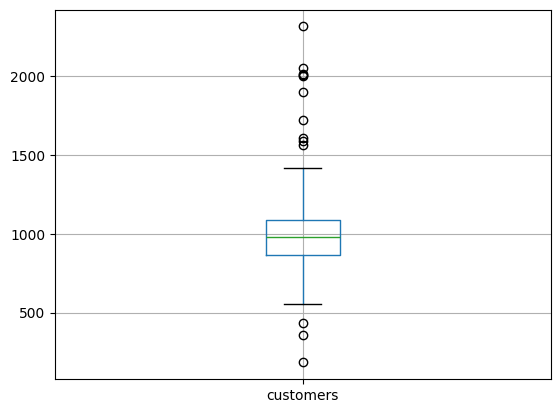

In [ ]:
df_ml_colab.boxplot('customers')

<Axes: xlabel='date'>

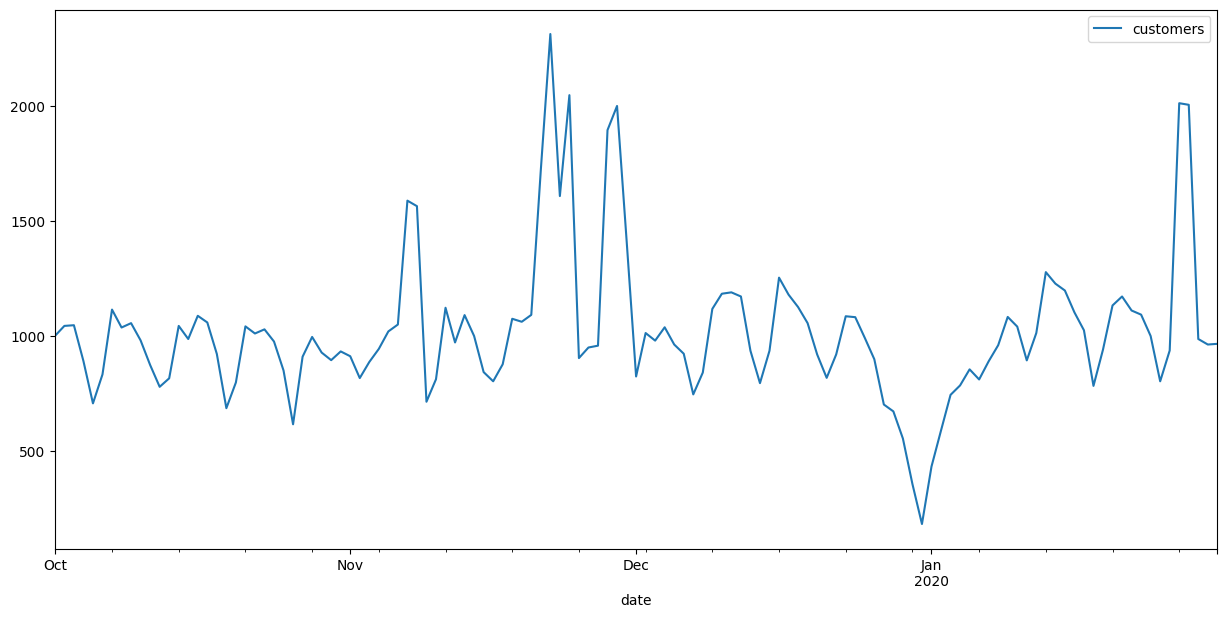

In [ ]:
df_ml_colab.plot(kind = "line", x = 'date', y = 'customers', figsize = (15,7))

In [ ]:
Q1 = df_ml_colab['customers'].quantile(0.25)
Q3 = df_ml_colab['customers'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

222.5


In [ ]:
df_ml_colab['month'] = df_ml_colab['date'].dt.month
df_ml_colab['customers_new'] = np.where((df_ml_colab['customers'] < (Q1 - 1.5 * IQR)) | (df_ml_colab['customers'] > (Q3 + 1.5 * IQR)),
                       df_ml_colab.groupby('month')['customers'].transform("median"), df_ml_colab['customers'])
df_ml_colab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           123 non-null    datetime64[ns]
 1   customers      123 non-null    int64         
 2   month          123 non-null    int64         
 3   customers_new  123 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 4.0 KB


In [ ]:
df_ml_colab.boxplot('customers_new')

<Axes: >

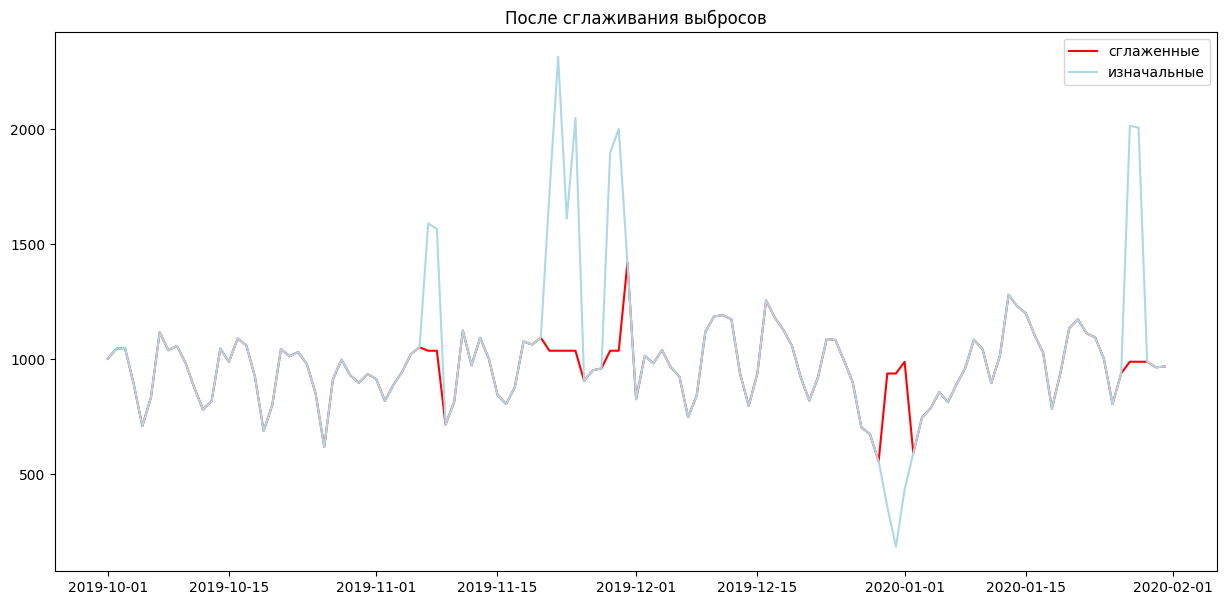

In [ ]:
plt.figure(figsize = (15,7))
plt.plot('date', 'customers_new', data = df_ml_colab, color = "red", label = "сглаженные")
plt.plot('date', 'customers', data = df_ml_colab, color = "lightblue", label = "изначальные")
plt.title("После сглаживания выбросов")
plt.legend(loc='best')
plt.show()

In [ ]:
df_ml_colab = df_ml_colab.drop(['month', 'customers'], axis = 1).rename(columns = {"customers_new":"customers"})
df_ml_colab.head()

,date,customers
0,2019-10-01,1001.0
1,2019-10-02,1045.0
2,2019-10-03,1048.0
3,2019-10-04,892.0
4,2019-10-05,708.0


#### Darts

In [ ]:
!pip install darts

In [ ]:
#Loading the package
from darts import TimeSeries
from darts.models import ExponentialSmoothing

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df_ml_colab, 'date', 'customers')

# Set aside the last 30 days as a test series to be used for predictions
train, val = series[:-30], series[-30:]

In [ ]:
model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

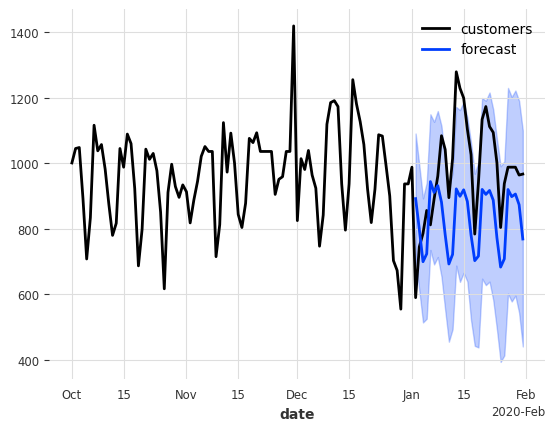

In [ ]:
series.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

#### GreyKite


In [ ]:
!pip install greykite

In [ ]:
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [ ]:
# Specifies dataset information
metadata = MetadataParam(
     time_col="date",  # name of the time column
     value_col="customers"  # name of the value column
     #freq= "MS" for Montly at start date
     #train_end_date='2019-12-01'
 )
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=df_ml_colab,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=30,  # forecasts 100 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata
    )
)

In [ ]:
ts = result.timeseries
fig = ts.plot()
plotly.io.show(fig)

In [ ]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

In [ ]:
fig = backtest.plot_components()
plotly.io.show(fig)